# Interactive tutorial: best practices for supervised machine learning in microbiomics

This Colab notebook is an accompaniment to the paper "Best practices for supervised machine learning in microbiomics" (**ADD CITATION**).

In this tutorial, we will develop a machine learning (ML) classifier that can predict whether an individual has schizophrenia based on the composition of their fecal microbiota. Data was sourced from [Zhu, Feng, et al. "Metagenome-wide association of gut microbiome features for schizophrenia." Nature communications 11.1 (2020): 1612.](https://www.nature.com/articles/s41467-020-15457-9) For more information about the clinical trial under which data was collected, including the study design and eligibility criteria, see [clinicaltrials.gov, identifier NCT02708316](https://clinicaltrials.gov/ct2/show/NCT02708316?term=NCT02708316&draw=2&rank=1).

If you're new to Colab:

- To run this notebook, you'll need to make your own copy by going to File > Save a copy in Drive.
- Code in cells can be run by clicking the play button on the lefthand side of the cell with your cursor or by using the keyboard shortcut "Command/Ctrl+Enter".
- To learn more about Colab, check out the [documentation](https://colab.research.google.com/#scrollTo=-Rh3-Vt9Nev9) and [FAQ](https://research.google.com/colaboratory/faq.html).

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import dill
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mealy.error_analyzer import ErrorAnalyzer
from mealy.error_visualizer import ErrorVisualizer

from ml4microbiome import data_visualization, pre_process, train

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
BASE_DIR = "./"  # change to your path

DATA_PATH = "zhu_metaphlan_read_counts.txt"
METADATA_PATH = "zhu_supplemental.tsv"

## Experimental design

**Goals:** 
1. Build an ML classifier that can distinguish between individuals with vs without schizophrenia using microbiome and/or clinical data. 
2. Understand why/how the model works.
3. Investigate which population segments it performs more or less well on. 

The data will be pre-processed as follows. While some may be more or less important for different projects and methodologies (e.g.: feature selection), we perform them here to illustrate how they can be incorporated into experimental design without data leakage. 
- CLR transform microbiome data
- Imputation (**add type**) of missing metadata entries
- Feature scaling (**add type**) on numerical metadata features
- Feature selection (**add type**)

We will compare the performance of models trained using the following parameters:
- Different types of features (metadata only, microbiome only, combined)
- Different ML algorithms (random forest, L1 logistic regression, LightGBM)
- Different taxonomic levels (species, genus, family, all taxonomic levels)

These comparisons will be performed using repeated, nested cross-validation (CV). Importantly, model selection will be performed on a nested CV set so that the performance of the final model will be evaluated on previously unseen data. 

Once our best model is selected, we will endeavour to explain how/why it makes predictions using Shapley Additive Explanations (SHAP). 

Finally, we will perform an error analysis to better understand under what circumstances our model may perform more or less well. 

## Data pre-processing

Raw reads were downloaded from the [European Nucleotide Archive Project PRJEB29127](https://www.ebi.ac.uk/ena/browser/view/PRJEB29127). Quality control analysis with FastQC v0.11.9 (Andrews, 2010) and MultiQC v1.12 (Ewels *et al*., 2016), revealing that reads in the dataset had high quality scores across their lengths and that there was minimal adapter content remaining. As such, we proceeded to remove human contamination by mapping reads against human reference genome [GRCh38.p14](https://www.ncbi.nlm.nih.gov/data-hub/genome/GCF_000001405.40/) using bowtie2 vX (Langmead & Salzberg, 2012). 

The taxonomic composition of samples was inferred  using [Metaphlan4](https://huttenhower.sph.harvard.edu/metaphlan/) (Segata *et al*., 2012; Blanco-Miguez *et al*., 2022) and the Jan 2021 ChocoPhlAn3 database as a reference (citation). Metaphlan4 was run with the -t rel_ab_w_read_stats flag to obtain read counts per taxon - this will later be normalized using the CLR transformation. One of the strengths of shotgun sequencing is that it can be used to profile the bacteria, archaea, eukaryotes, and viruses in a sample, all of which can influence community ecology and host phenotype. By default, Metaphlan4 will profile bacterial, archaeal, and eukaryotic taxa. We added the --add_viruses flag to include information about viral taxa present in metagenomes. 

**Best practices:**

- For software tools, databases, and reference genomes, note the version used. In rare instances where the distributor does not specify explicit versions, state the date on which you accessed them.
- For software tools, describe whether you used default parameters vs customized settings. If the latter, explain which settings you used and why.

In [4]:
df = pd.read_csv(BASE_DIR + DATA_PATH, sep="\t", header=1, index_col=0)
df.head(10)

,wHAXPI032581-18,wHAXPI032582-19,wHAXPI032583-21,wHAXPI032584-22,wHAXPI032585-23,wHAXPI032586-25,wHAXPI032587-26,wHAXPI032588-27,wHAXPI032589-28,wHAXPI032590-29,...,wHAXPI034926-15,wHAXPI037144-8,wHAXPI037145-9,wHAXPI037146-11,wHAXPI037147-12,wHAXPI043592-8,wHAXPI043593-9,wHAXPI043594-11,wHAXPI047830-11,wHAXPI048670-90
clade_name,,,,,,,,,,,,,,,,,,,,,
UNCLASSIFIED,3494672.0,6754349.0,4260914.0,6187478.0,2674039.0,7947679.0,5613767.0,866739.0,3572242.0,244159.0,...,0.0,8123538.0,14037729.0,1826625.0,0.0,7334007.0,2717037.0,1497137.0,24400.0,1965115.0
k__Bacteria,55201537.0,47765462.0,52657193.0,52561280.0,59600789.0,55916608.0,49243118.0,49442596.0,46909477.0,2645156.0,...,88900925.0,58777577.0,58748372.0,73703777.0,67259161.0,76057026.0,84384204.0,78882064.0,61148785.0,53749396.0
k__Bacteria|p__Bacteroidetes,33897963.0,46389419.0,39207459.0,49916347.0,37934782.0,38316045.0,13636655.0,35392296.0,40287619.0,2071752.0,...,80858718.0,40154561.0,51010514.0,41339096.0,56440790.0,67479230.0,68517753.0,67397038.0,47634395.0,31936734.0
k__Bacteria|p__Firmicutes,17430112.0,1186849.0,12641757.0,2330571.0,19271903.0,14195178.0,21301098.0,12746923.0,6349586.0,553860.0,...,5928344.0,14832338.0,6835368.0,25314983.0,7948970.0,7234829.0,12394020.0,6367626.0,8208873.0,18262886.0
k__Bacteria|p__Candidatus_Melainabacteria,1305775.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Bacteria|p__Proteobacteria,2050064.0,146776.0,685236.0,158460.0,1540153.0,3146510.0,2657902.0,669421.0,244318.0,9886.0,...,1476132.0,2294263.0,792078.0,2575712.0,2352246.0,1334652.0,1197989.0,4701450.0,3807054.0,3517502.0
k__Bacteria|p__Actinobacteria,499243.0,42418.0,122663.0,155902.0,823945.0,245698.0,11638943.0,548737.0,22276.0,9658.0,...,637731.0,256420.0,78597.0,4472361.0,516776.0,2815.0,352808.0,407943.0,1496547.0,29167.0
k__Bacteria|p__Synergistetes,12198.0,0.0,0.0,0.0,642.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24618.0,0.0,0.0,0.0
k__Bacteria|p__Verrucomicrobia,6182.0,0.0,0.0,0.0,0.0,13177.0,0.0,85219.0,5678.0,0.0,...,0.0,345048.0,0.0,0.0,232.0,5500.0,1896031.0,5139.0,0.0,1347.0


It is essential that ML practitioners understand the format of raw input data before developing models. Here, we are working with the profile file output by Metaphlan4. 

Each column represents a sample and each row represents a taxon that was identified in the dataset. Values in cells represent the number of reads per sample attributed to a given taxon. For every taxonomic level (kingdom, phylum, ... genus, species), metaphlan outputs the read counts of all taxa identified at that level. Taxonomic levels are denoted by "k__" for kingdom, "p__" for phylum, ..., "g__" for genus, "s__" for species. This means that some rows will be redundant. For example, reads asigned to the species *Escherichia coli* will also be counted under genus *Escherichia*, family Enterobacteriaceae, Order Enterobacterales, Phylum Pseudomonadota, and Kingdom Bacteria. 

For more information, see the [Metaphlan4 tutorial](https://github.com/biobakery/biobakery/wiki/metaphlan4#131-the-metaphlan-taxonomic-profile).

In [5]:
df_metadata = pd.read_csv(
    BASE_DIR + METADATA_PATH, skiprows=3, index_col=0, sep="\t"
).iloc[:, :-4]
df_metadata = df_metadata.replace(
    to_replace="Xi'An Mental Health Center", value="Xi'an"
)
df_metadata.head()

,Age,"Gender (1:male, 2:female)",Marital status,Dwelling condition,Education level,Sample center,BMI,Group,Diagnosis,Height(cm),...,In the past six months exposure to secondhand smoke situation,Tryptophane(μM),Glutamic acid(μM),Tyrosine(μM),Phenylalanine(μM),Dopamine(ng/ml),Gamma-aminobutyric acid (GABA)(ng/L),Serotonin(ng/ml),Kynurenine (KYN)(nmol/L),Kynurenic acid (KYNA)(nmol/L)
BGI ID,,,,,,,,,,,,,,,,,,,,,
wHAXPI032581-18,25,2,single,group living,college,Xi'an,19.47,HC,healthy,165,...,almost none,1.0516,12.422,80.545284,63.896120,13.024398,361.400990,897.702,272.868494,19.118564
wHAXPI032582-19,31,1,married,famliy life,junior college,Xi'an,21.77,HC,healthy,166,...,less than 1 hour a day,1.4955,19.352,75.147635,66.953205,20.294400,505.238478,876.188,246.388882,28.348535
wHAXPI032583-21,20,2,single,group living,college,Xi'an,18.96,SCZ,first-episode,164,...,almost none,0.9545,11.134,60.190960,49.082874,13.337798,126.780552,3855.892,282.426914,21.620503
wHAXPI032584-22,14,1,single,famliy life,junior high school,Xi'an,16.02,SCZ,first-episode,158,...,less than 1 hour a day,1.0566,14.501,90.816270,72.480174,16.201674,318.151574,4676.200,278.668462,18.302654
wHAXPI032585-23,27,1,single,famliy life,primary school,Xi'an,19.61,SCZ,relapse,172,...,almost none,0.7695,10.197,51.945472,48.217204,8.616032,312.728082,676.074,326.729434,47.202890


In [6]:
df_metadata.isnull().any().any()

True

Looking at the metadata, a couple things to note are:
- Some metadata columns contain NaNs, we will perform imputation to deal with those later. Importantly, imputation must be done after the training-test split for model evaluation, so as to avoid data leakage.
- Categorical features such as "Gender" should be one hot encoded.
- Behavioural features may be affected by whether or not an individual is aware that they have diagnosed schizophrenia. For example, an individual with severe schizophrenia may be more or less likely to live in a certain type of housing ("Dwelling condition"). Since we want to develop a classifier that would theoretically be able to predict whether individuals without diagnosed schizophrenia may have schizophrenia, we will not include behavioural features in our ML model.

**Best practices:**  
- Understand the format of data and metadata that will be used as input to the ML experiment
- Carefully consider whether metadata could include features that can result in data leakage

## Data Exploration

Before designing our ML experiment, we will perform data exploration to understand the dataset available. 

This includes characterizing:
- Dataset size
- Demographics of the population sampled
- Technical features relating to how the data was generated (e.g.: collection, sampling, and processing methods)
- Properties of the sequenced dataset, such as the # of species identified by Metaphlan4

In [7]:
# Note: let's not do any data exploration until we see what the ML results look like
# and if we want to use this dataset for the final tutorial

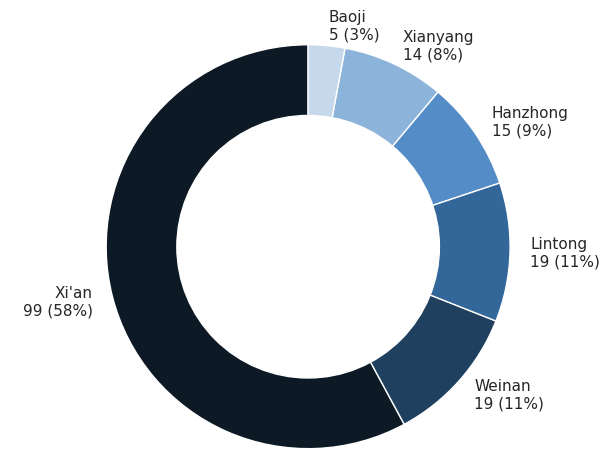

In [8]:
fig = data_visualization.pie_plot_hospital(df_metadata)

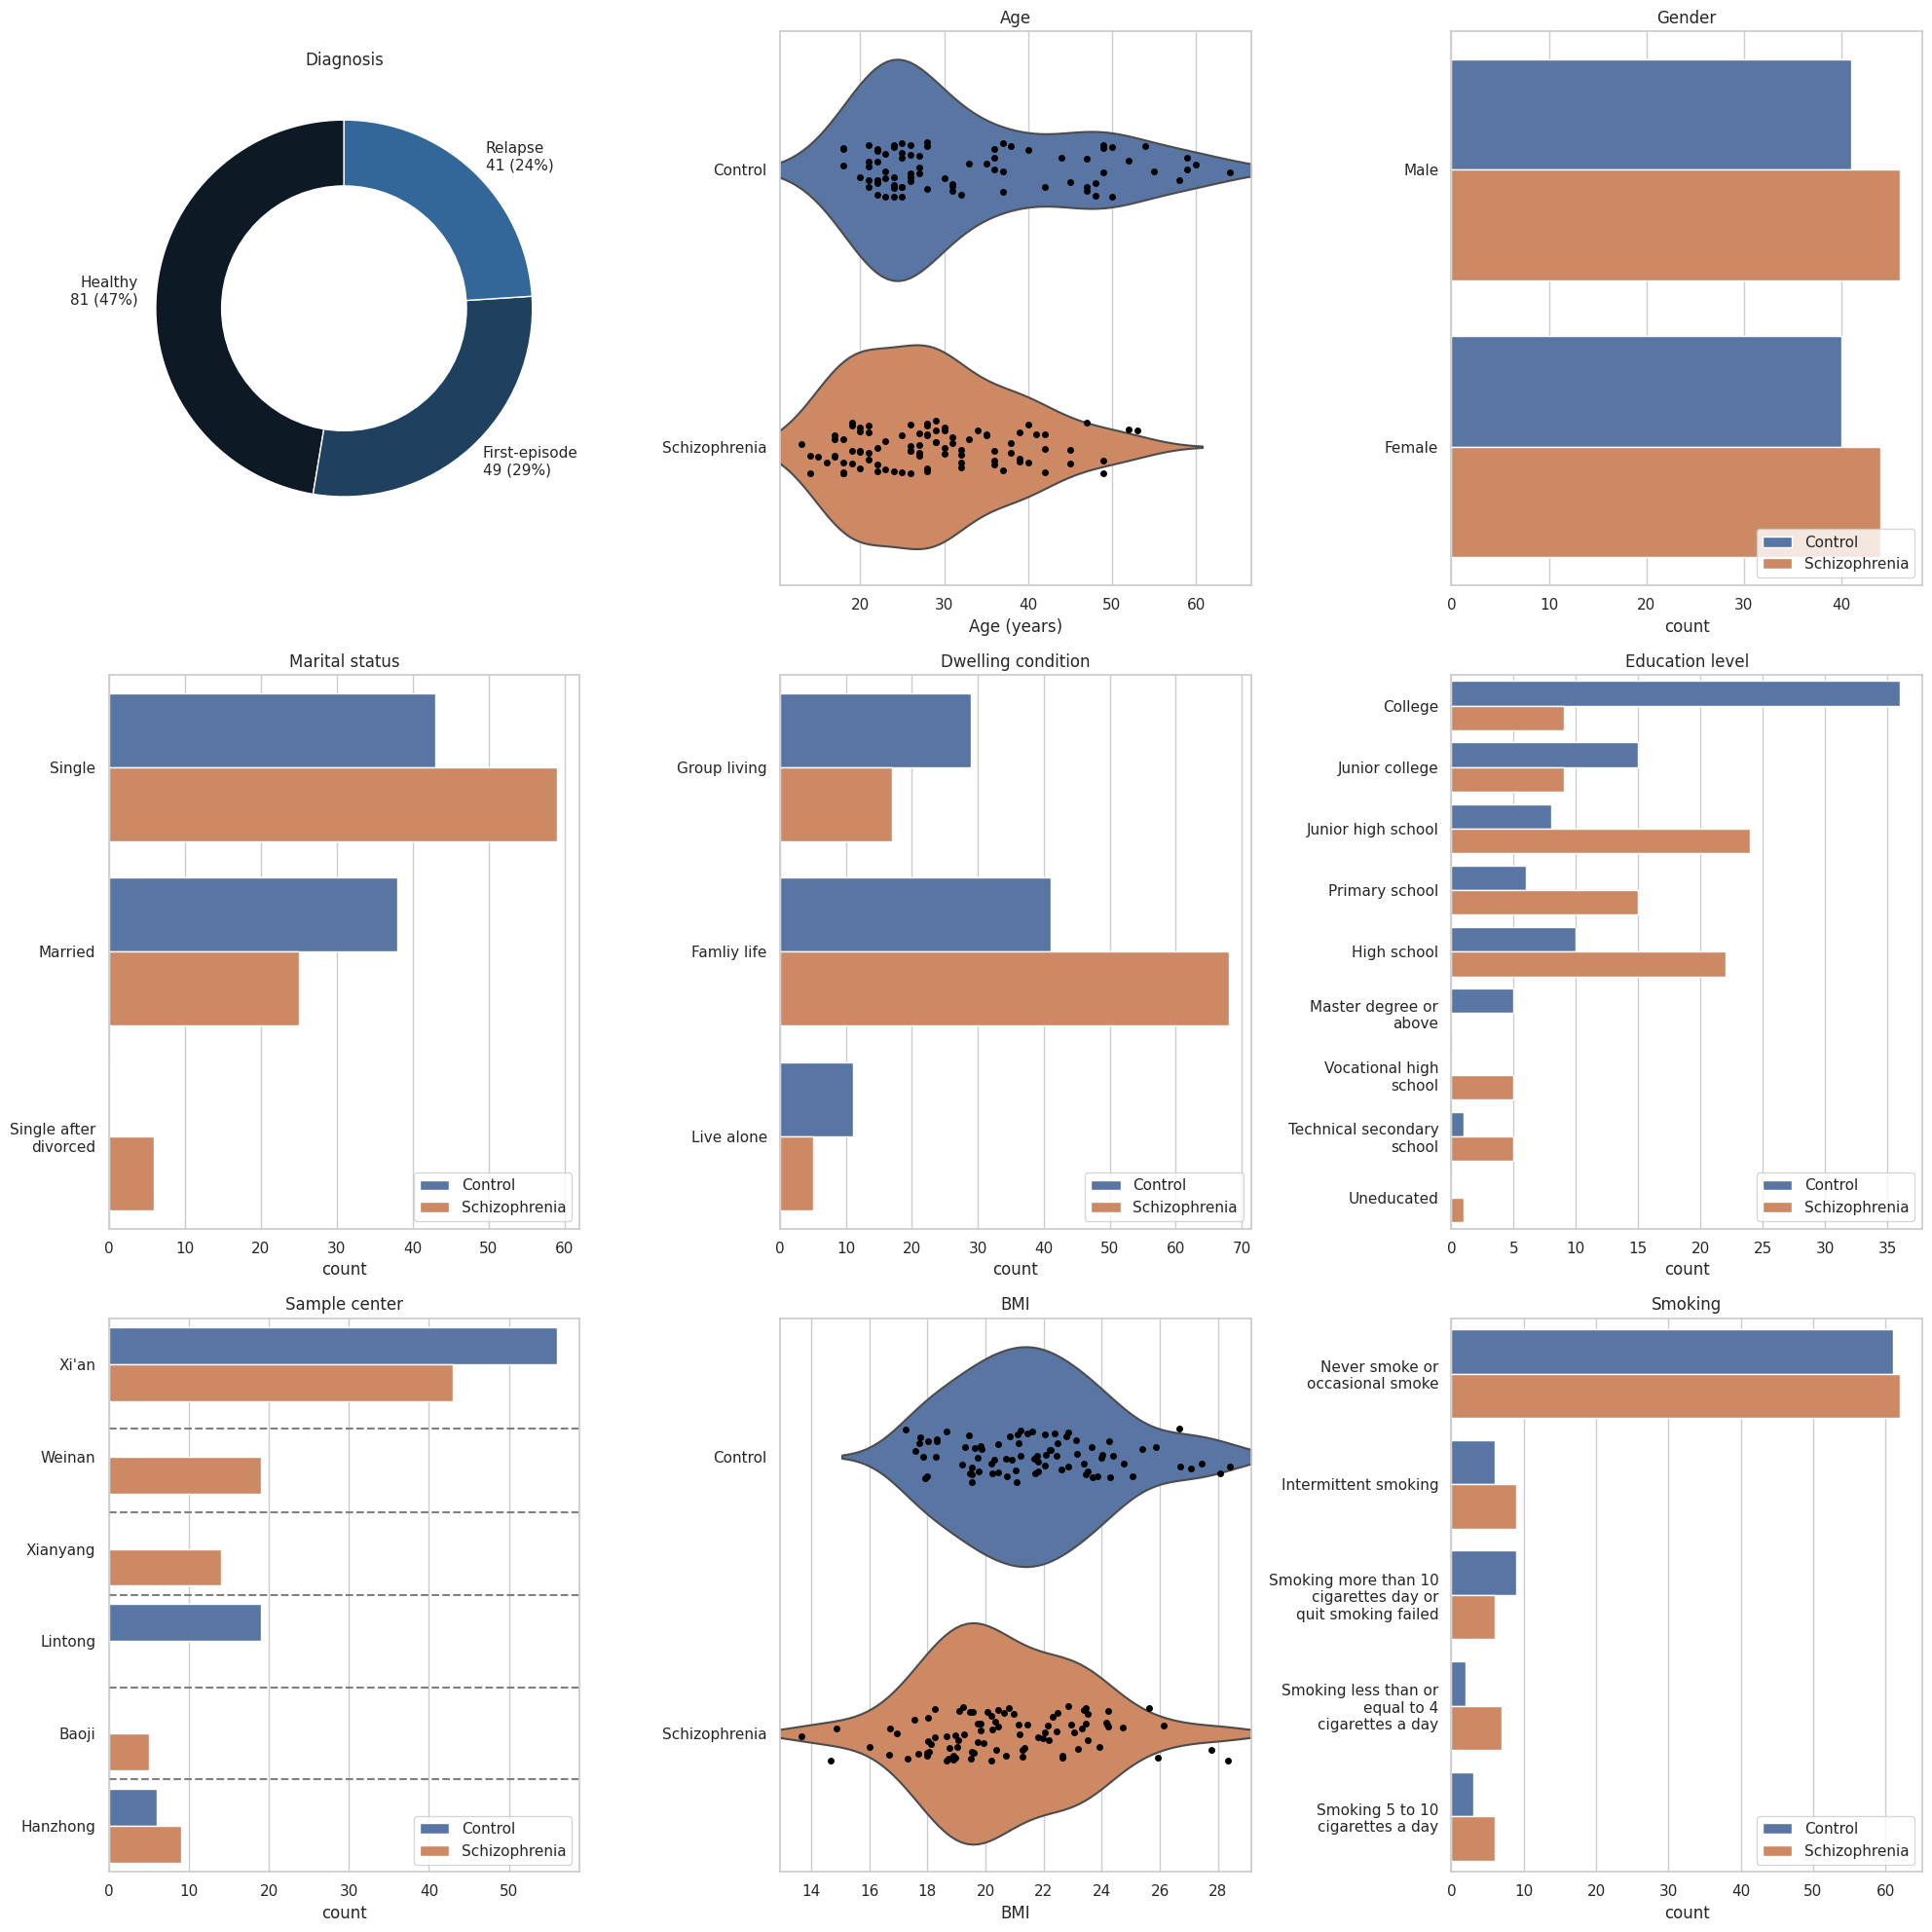

In [9]:
fig = data_visualization.plot_demographics(df_metadata)

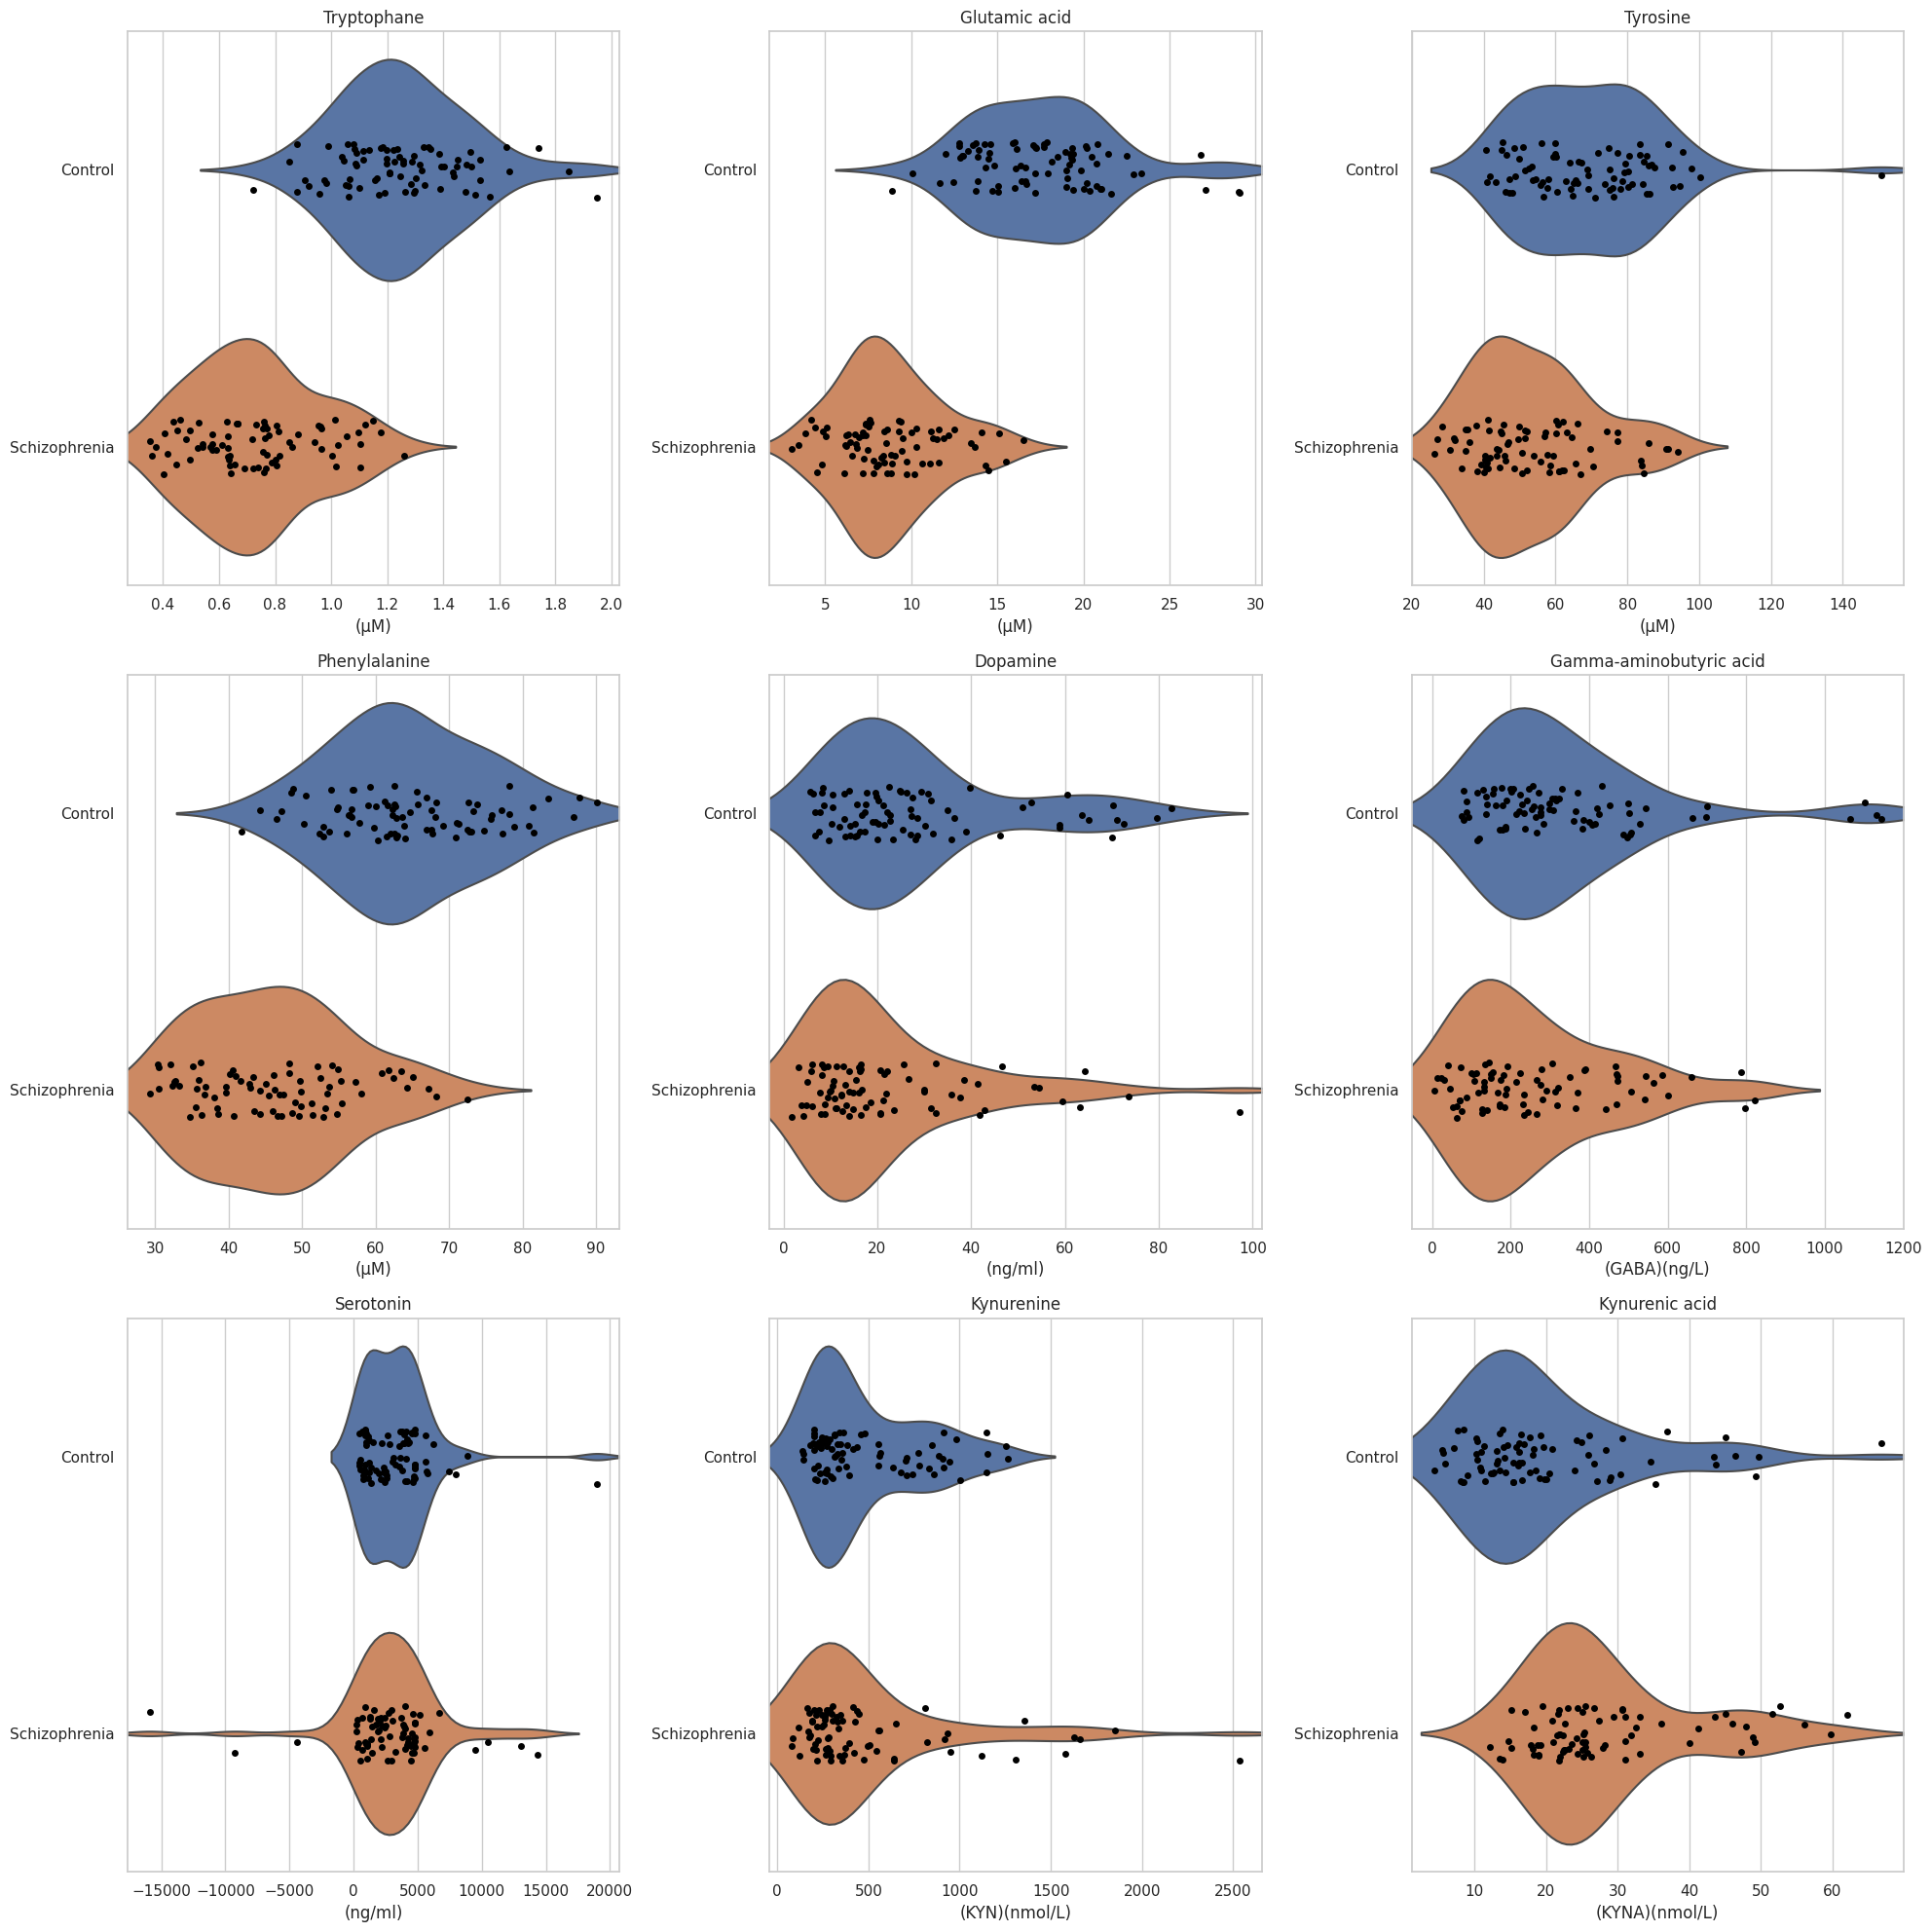

In [10]:
fig = data_visualization.plot_blood_based_biomarkers(df_metadata)

In [11]:
df_genus = df[(df.index.str.contains("g__")) & ~(df.index.str.contains("s__"))]

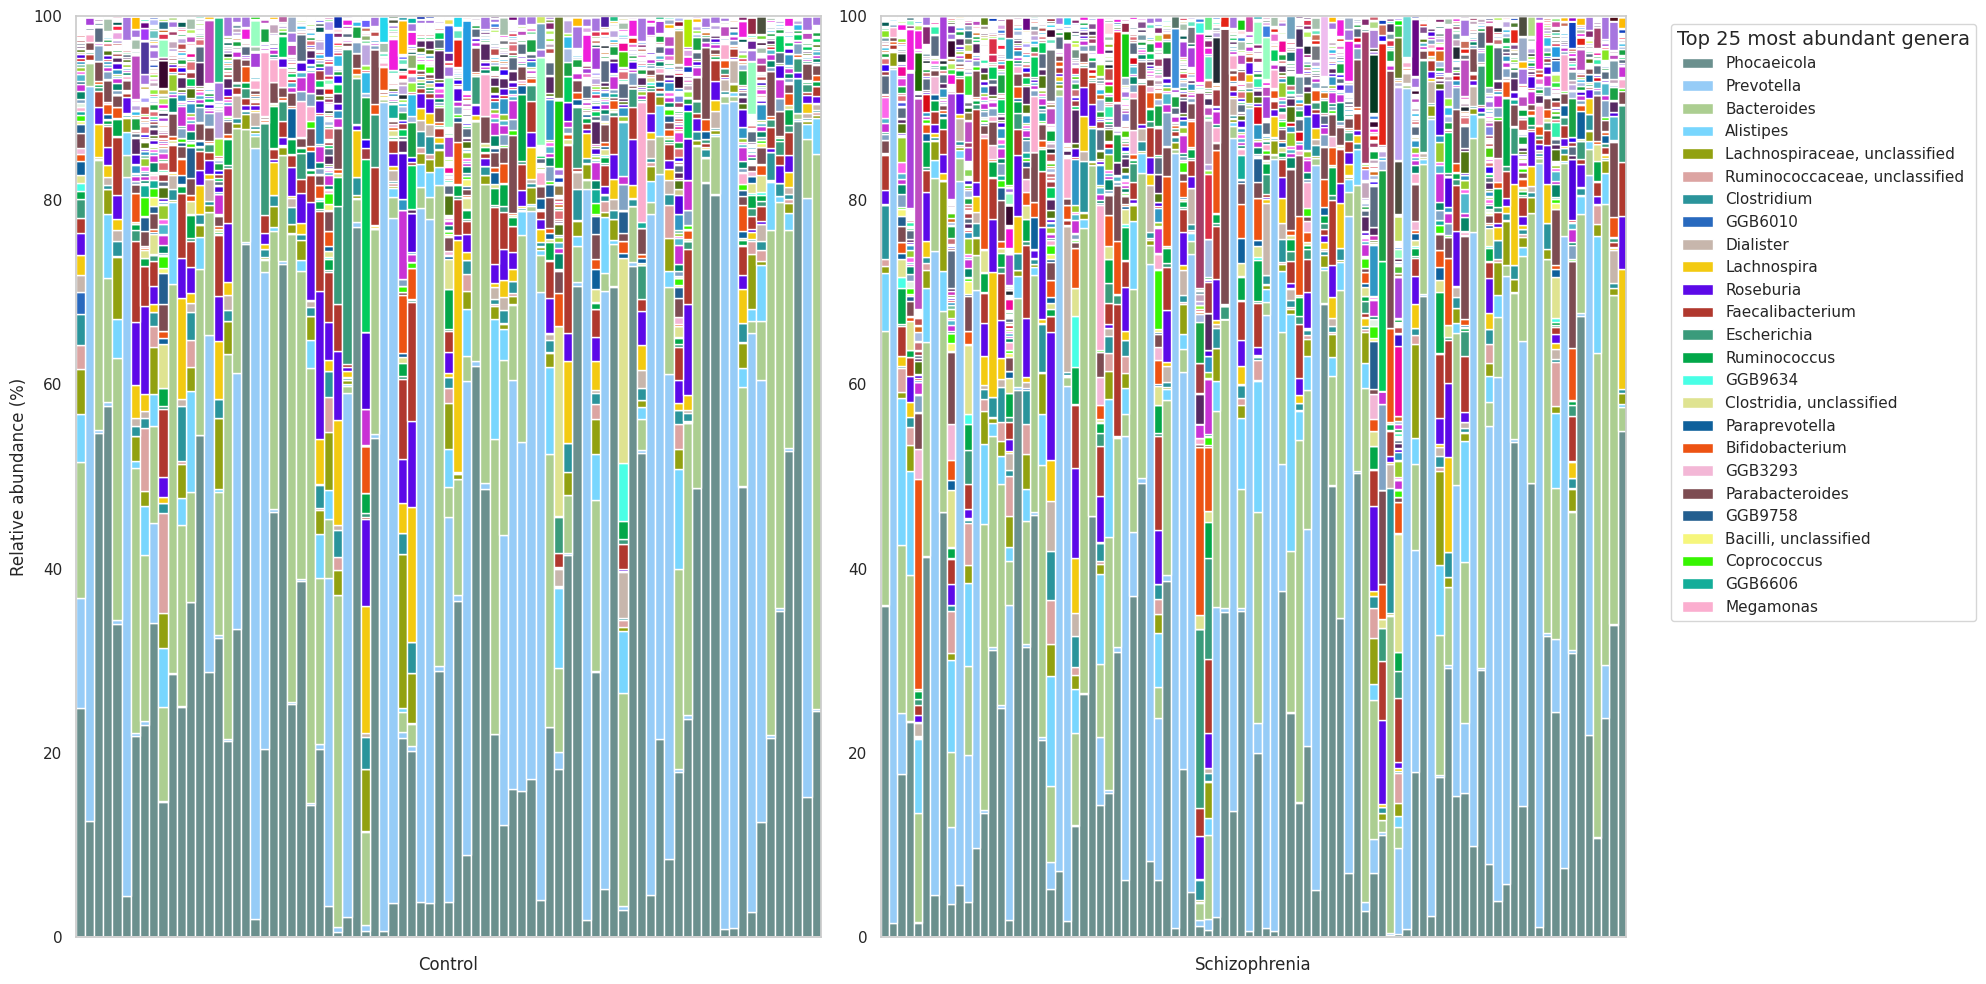

In [12]:
df_genus_rel_ab = df_genus.apply(lambda x: x * 100 / sum(x), axis=0).copy()

fig = data_visualization.plot_genus(
    df_genus_rel_ab,
    df_metadata[df_metadata["Group"] == "HC"].index.to_list(),
    df_metadata[df_metadata["Group"] == "SCZ"].index.to_list(),
)

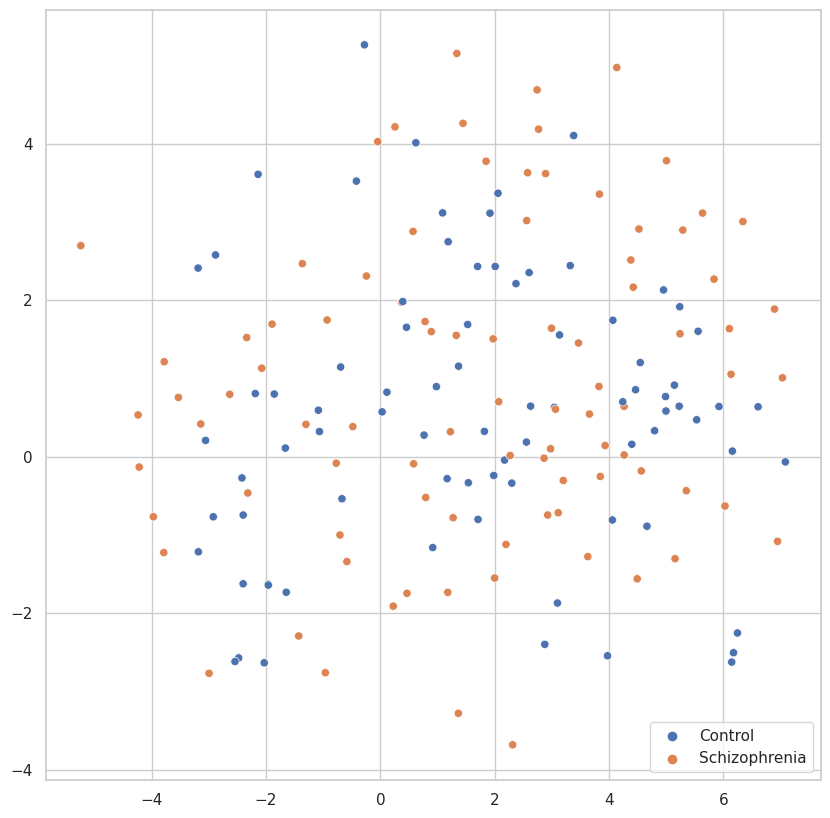

In [13]:
df_clr = pre_process.clr_transform(df_genus).T

fig = data_visualization.plot_tsne(df_clr, df_metadata["Group"], 11)

In [14]:
# TODO: data exploration and visualization
# E.g.: participant demographics (age, sex)
# E.g.: distribution of patients (and diagnoses) per hospital center

## Pre-process data 

To account for the compositionality of microbiomics data, we will apply the centered log ratio (CLR) transformation. We will not use relative abundance because ____. To avoid data leakage, other types of data pre-processing (feature scaling, feature selection) must be applied only once the training-test split has been made for evaluating model performance. The difference between CLR vs something like feature scaling is that CLR is calculate per sample, whereas the statistics used for feature scaling are calculated across multiple samples. 

In [15]:
tax_levels = ["all", "species", "genus", "family"]

In [16]:
data_dict = defaultdict(lambda: defaultdict())

In [17]:
# Create dfs with specific taxonomic levels (e.g.: species only)
# CLR transform microbiome datasets
for tax_level in tax_levels[1:]:
    _ = pre_process.get_tax_level(df, tax_level)
    data_dict["microbiome_only"][tax_level] = pre_process.clr_transform(_).T

data_dict["microbiome_only"]["all"] = pre_process.clr_transform(df).T

In [18]:
# Format target labels
# Target = whether or not a study participant has schizophrenia
y = df_metadata["Group"].replace(to_replace="HC", value="NS")  # NS = No schizophrenia

In [19]:
# For metadata, we will retain only features that derive from objective clinical measurements
X_metadata_only = df_metadata[
    [
        "Age",
        "Height(cm)",
        "Weight(kg)",
        "Pulse(c. p. m)",
        "Breathe(c. p. m)",
        "Systolic pressure(mmHg)",
        "Diastolic pressure(mmHg)",
        "Tryptophane(μM)",
        "Glutamic acid(μM)",
        "Tyrosine(μM)",
        "Phenylalanine(μM)",
        "Dopamine(ng/ml)",
        "Gamma-aminobutyric acid  (GABA)(ng/L)",
        "Serotonin(ng/ml)",
        "Kynurenine (KYN)(nmol/L)",
        "Kynurenic acid (KYNA)(nmol/L)",
    ]
]
metadata_continuous_cols = X_metadata_only.columns

In [20]:
# Now we'll one hot encode "Gender" -- a categorical feature
# rows are samples, columns are features
gender = pd.get_dummies(df_metadata["Gender (1:male, 2:female)"])
X_metadata_only = pd.merge(X_metadata_only, gender, left_index=True, right_index=True)
data_dict["metadata_only"]["all"] = X_metadata_only

#### TODO: add headers back in for columns

In [21]:
# # Merge metadata with microbiome data (at different taxonomic levels)
data_dict = pre_process.merge_metadata_microbiome(data_dict, tax_levels)

## Perform feature selection, model training, and hyperparameter tuning using nested 10-fold cross-validation

[Add text explaining strengths of our experimental design]

In [22]:
# TODO: Section on choosing k for k-fold CV
# Talk about why you might want k=5 vs k=10, some combination thereof, etc
# Think through how many samples you have, and how many of each class
# Here, 171 samples - 81 HC, 90 SCZ (df_metadata["Group"].value_counts())
# Stratified 10-fold CV:
#   17*9=153 for training fold, 17 samples for test fold
# When nested, with 5-fold CV:
#   153/5 = 30 ---> 30*4=120 for training, 30 for test -- ~15 HC and 15 SCH
# For a smaller dataset, however, 10-fold CV might not make sense,
#   especially if there is a strong class imbalance

In [23]:
# Record time and memory usage to record models?

In [24]:
# Encode labels
encoder = LabelEncoder()
y_encoded = pd.Series(encoder.fit_transform(y))

In [25]:
# Save data_dict and y_encoded as pickle files
with open("./data_dict.pickle", "wb") as data_dict_file:
    dill.dump(data_dict, data_dict_file)

with open("./y_encoded.pickle", "wb") as y_encoded_file:
    dill.dump(y_encoded, y_encoded_file)

## Select best model based on CV results

In [26]:
with open("./inner_results.pickle", "rb") as inner_results_file:
    inner_results = dill.load(inner_results_file)

with open("./outer_results.pickle", "rb") as outer_results_file:
    outer_results = dill.load(outer_results_file)

In [27]:
# For each trained model, calculate median CV result plus standard deviation
# Use median AUROC to select best model

# Find maximum median AUROC
max_median_auroc = 0

for data_type_key, data_type_value in outer_results.items():
    for tax_level_key, tax_level_value in data_type_value.items():
        for alg_key, alg_value in tax_level_value.items():
            max_auroc = max(alg_value["inner_median_valid_AUROC"])
            if max_auroc > max_median_auroc:
                max_median_auroc = max_auroc

max_median_auroc

0.9307692307692308

In [28]:
# Find all models that have max_median_auroc

best_models_info = []
tolerance = 1e-6  # 0.000001

for data_type_key, data_type_value in outer_results.items():
    for tax_level_key, tax_level_value in data_type_value.items():
        for alg_key, alg_value in tax_level_value.items():
            for ind, value in enumerate(alg_value["inner_median_valid_AUROC"]):
                if abs(value - max_median_auroc) < tolerance:
                    best_models_info.append(
                        {
                            "data_type": data_type_key,
                            "tax_level": tax_level_key,
                            "alg": alg_key,
                            "params": alg_value["params"][ind],
                            "random_state": ind,
                            "outer_iter_no": ind,
                            "test_AUROC": alg_value["AUROC"][ind],
                            "elapsed_time": alg_value["elapsed_time"][ind],
                        }
                    )

best_models_info

[{'data_type': 'metadata_only',
  'tax_level': 'all',
  'alg': 'random_forest',
  'params': {'n_estimators': 100,
   'min_samples_split': 8,
   'min_samples_leaf': 4,
   'max_features': 'log2',
   'max_depth': 5,
   'bootstrap': False},
  'random_state': 5,
  'outer_iter_no': 5,
  'test_AUROC': 0.8839869281045751,
  'elapsed_time': datetime.timedelta(seconds=24, microseconds=725660)}]

## Evaluate performance of the best model on the test set

In [29]:
# We already calculated the performance of each model on the test set
# Access those scores for the best model
for num, model_info in enumerate(best_models_info, 1):
    print(f"#{num}:")
    print(f"\tData Type: {model_info['data_type']}")
    print(f"\tTaxonomic Level: {model_info['tax_level']}")
    print(f"\tLearning Algorithm: {model_info['alg']}")
    print(f"\tAUROC: {model_info['test_AUROC']}")
    print(f"\tElapsed Time: {model_info['elapsed_time']}")

#1:
	Data Type: metadata_only
	Taxonomic Level: all
	Learning Algorithm: random_forest
	AUROC: 0.8839869281045751
	Elapsed Time: 0:00:24.725660


## Evaluate performance of the best model on an external validation set

## Retrain the model for interpretation and error analysis

In [30]:
test_size = 0.2
model_info = best_models_info[0]

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(
    data_dict[model_info["data_type"]][model_info["tax_level"]],
    y_encoded,
    test_size=test_size,
    stratify=y_encoded,
    random_state=model_info["random_state"],
)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

if model_info["data_type"] != "microbiome_only":
    X_train, X_test = pre_process.scale_features(
        X_train, X_test, metadata_continuous_cols
    )

model = train.train_model(
    model_info["alg"],
    X_train,
    y_train,
    model_info["random_state"],
    model_info["params"],
)

## Perform model interpretation

In [31]:
X_test = X_test.astype(float)
explainer = shap.Explainer(model.predict, X_test.to_numpy())
shap_values = explainer(X_test)

In [32]:
# Replace the feature list
selected_features = [
    "Age",
    "Pulse(c. p. m)",
    "Tryptophane(μM)",
    "Glutamic acid(μM)",
    "Phenylalanine(μM)",
]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


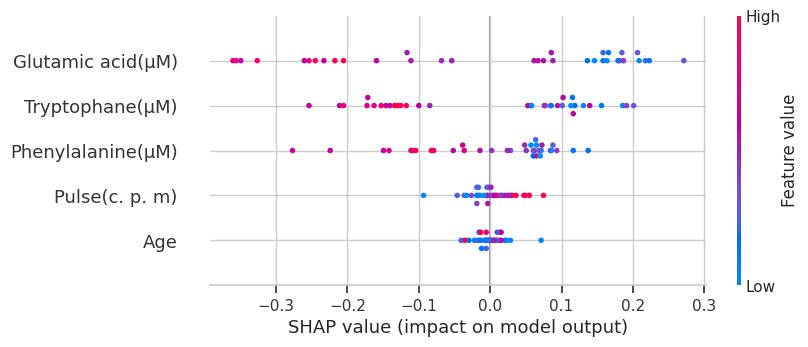

In [33]:
shap.plots.beeswarm(shap_values[:, selected_features])

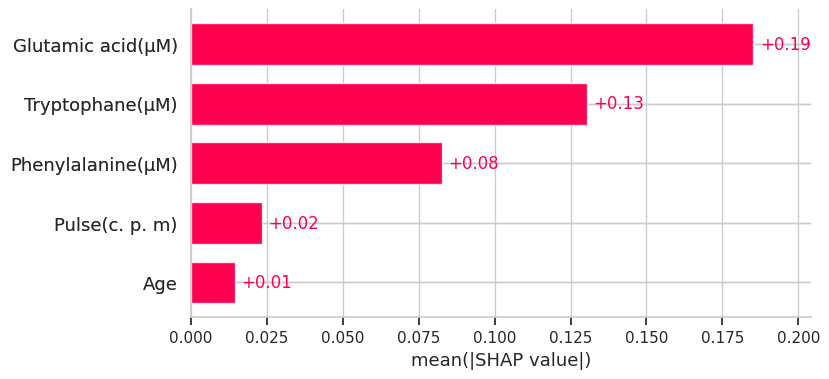

In [34]:
shap.plots.bar(shap_values[:, selected_features])

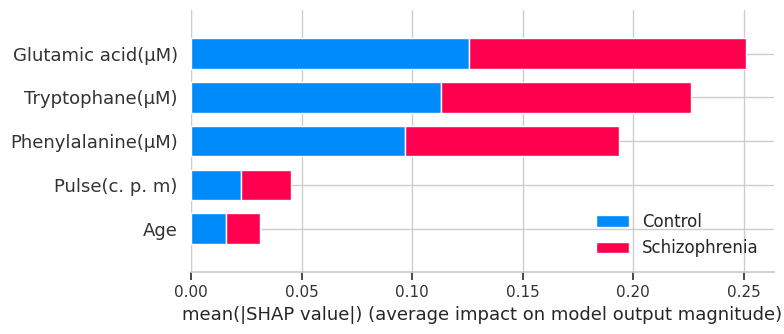

In [35]:
explainer_bar = shap.Explainer(model)
shap_values_bar = explainer_bar.shap_values(X_test)
selected_shap_values_bar = [
    shap_values_bar[0][:, X_test.columns.isin(selected_features)],
    shap_values_bar[1][:, X_test.columns.isin(selected_features)],
]
shap.summary_plot(
    selected_shap_values_bar,
    X_test[selected_features],
    plot_type="bar",
    class_names=["Control", "Schizophrenia"],
)

## Perform error analysis

In [37]:
# E.g.: Does the model perform better or worse on people of different ages, sex
# E.g.: Does the model have some sort of bias based on hospital center

# To fit analyzer requires at least 100 samples, otherwise raises ValueError
X_test_oversampled = pd.concat([X_test, X_test, X_test])
X_test_oversampled.columns = map(str, X_test.columns)

y_test_oversampled = pd.concat([y_test, y_test, y_test])

error_analyzer = ErrorAnalyzer(
    model, feature_names=list(X_test_oversampled.columns), random_state=42
)
error_analyzer.fit(X_test_oversampled, y_test_oversampled)

print(error_analyzer.evaluate(X_test, y_test, output_format="str"))

mealy | INFO - Preparing the Error Analyzer Tree...
mealy | INFO - The primary model has an error rate of 0.114
mealy | INFO - Fitting the Error Analyzer Tree...
mealy | INFO - Grid search the Error Tree with the following grid: {'max_depth': [5, 10], 'min_samples_leaf': array([0.002, 0.004, 0.006, 0.008, 0.01 ])}
mealy | INFO - Chosen parameters: {'max_depth': 5, 'min_samples_leaf': 0.002}
mealy | INFO - The primary model has an error rate of 0.114


The Error Decision Tree was trained with accuracy 100.00% and balanced accuracy 100.00%.
The Decision Tree estimated the primary models accuracy to 88.57%.
The true accuracy of the primary model is 88.57.%
The Fidelity of the error tree is 100.00%.
The error tree is considered representative of the primary model performances.



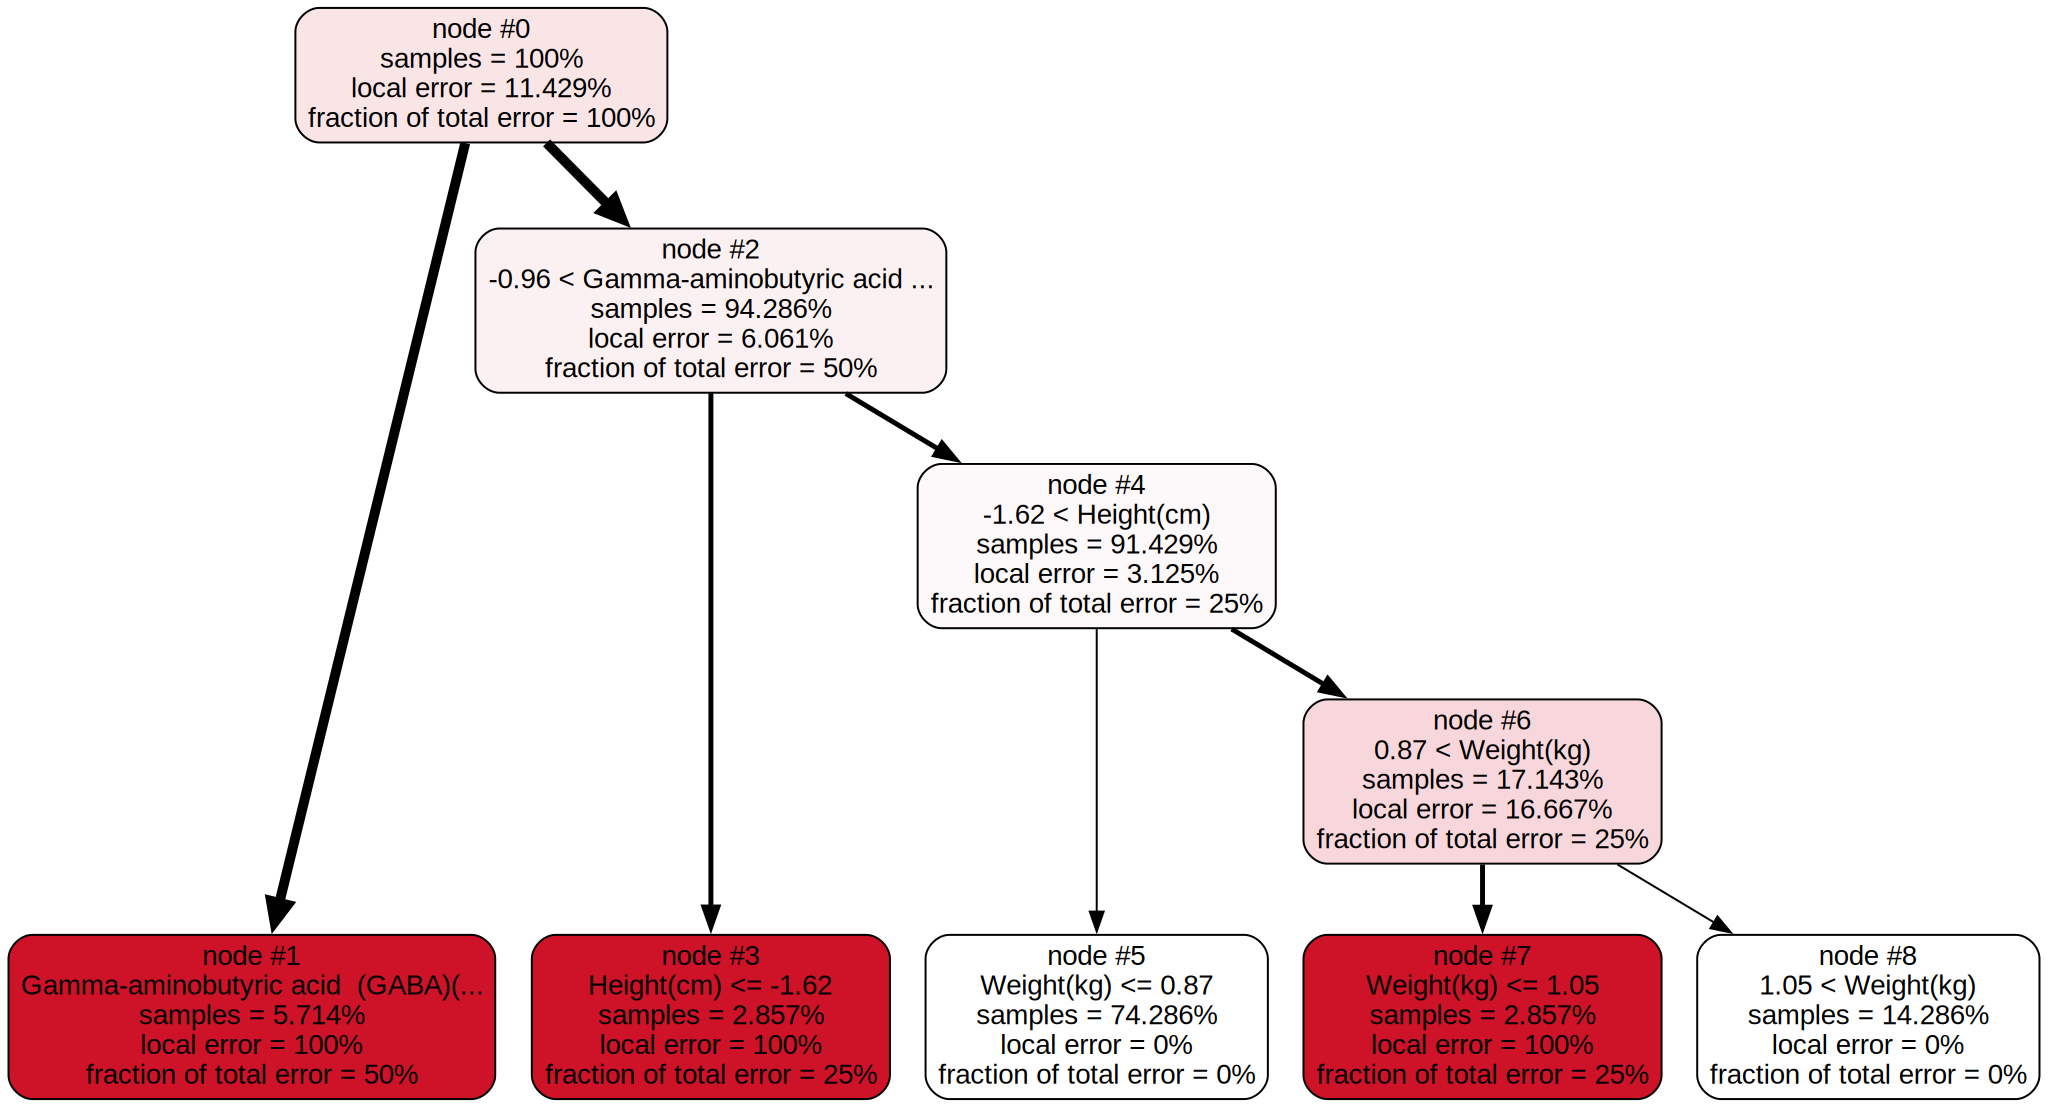

In [38]:
error_visualizer = ErrorVisualizer(error_analyzer)
error_visualizer.plot_error_tree()

## Ensure that the work is reproducible

In [37]:
# Add talking points about how to make the work reproducible

## Conclusion

Provide example of what to report / language to use

## Works Cited

Andrews, S. "FastQC: a quality control tool for high throughput sequence data." (2010). Available online at: http://www.bioinformatics.babraham.ac.uk/projects/fastqc/.

Ewels, P., Magnusson, M., Lundin, S., Käller, M. "MultiQC: summarize analysis results for multiple tools and samples in a single report." *Bioinformatics* 32.19 (2016): 3047-3048.

Zhu, F., *et al*. "Metagenome-wide association of gut microbiome features for schizophrenia." *Nature communications* 11.1 (2020): 1612.

Langmead, B., Salzberg, S.L. "Fast gapped-read alignment with Bowtie 2." *Nature methods* 9.4 (2012): 357-359.